__UNet - perception loss in fastai v2 - Basemodel_Hagen__

In [1]:
from fastai.vision.all import *
import os
import pathlib
import cv2
import fastai; fastai.__version__

'2.7.16'

In [2]:
torch.cuda.set_device(4)

In [3]:
torch.cuda.current_device(), torch.cuda.get_device_name(0)

(4, 'NVIDIA A100 80GB PCIe')

In [4]:
# set to toch.device("cpu"), if you do not have a graphic card to work with!
device=torch.device("cuda")

In [5]:
path = pathlib.Path(os.getcwd())

In [6]:
path_GT = path/'Daten/Hagen_GT'
path_noisy = path/'Daten/Hagen_noisy'
"""
use the following path for Actin data only
path_GT = path/'Daten/Hagen_actin_GT'
path_noisy = path/'Daten/Hagen__noisy'
"""

"\nuse the following path for Actin data only\npath_GT = path/'Daten/Hagen_actin_GT'\npath_noisy = path/'Daten/Hagen__noisy'\n"

In [7]:
# set seeds for everything for reproducibility
%run set_seeds.ipynb

In [8]:
# run Dataloader
%run Dataloader_Hagen.ipynb

In [9]:
# run notebook to set loss 
%run Perception_loss.ipynb

/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# apply dataloader with batchsize of 38 for RTX4060, 16GB - loss weights may need be tuned for other bs
dls_den, dblock = get_dls(38)

In [11]:
# setup loss function and weights for indiviual loss components - approximately equal loss in first epoch
#loss_func = FeatureLoss(vgg_m, blocks[2:5],[100], [5,15,17], [3,22,21])    # aedequate weights for actin only
loss_func = FeatureLoss(vgg_m, blocks[2:5],[100], [6,16,19], [4,25,22])    # tuned weights for all Hagen data

In [12]:
# set metrics to track individual loss components 
metrics = LossMetrics(loss_func.metric_names)

In [13]:
# set file name and tracking information to store training metrics
fname = 'Basemodel_Hagen_all'
cbs = CSVLogger(fname=fname+'.csv')                                                

In [14]:
# define model architecture and parameters, pretrained false sets all layers as trainable
def create_gen_learner():
    return unet_learner(dls_den, bbone, loss_func=loss_func, blur=True, norm_type=NormType.Weight, 
                        self_attention=True, y_range=y_range, pretrained=False, weights=None,
                        metrics=metrics, cbs=cbs
                        )

In [15]:
# create denoising learner
learn_den = create_gen_learner()
learn_den.to_fp16()
learn_den.summary() # to check that all layers are trainable

/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/fastai/callback/fp16.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


DynamicUnet (Input shape: 38 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     38 x 64 x 128 x 128 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     38 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                     

/home/dlohr/mambaforge/envs/fastai2/lib/python3.10/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=de

SuggestedLRs(valley=0.0003311311302240938)

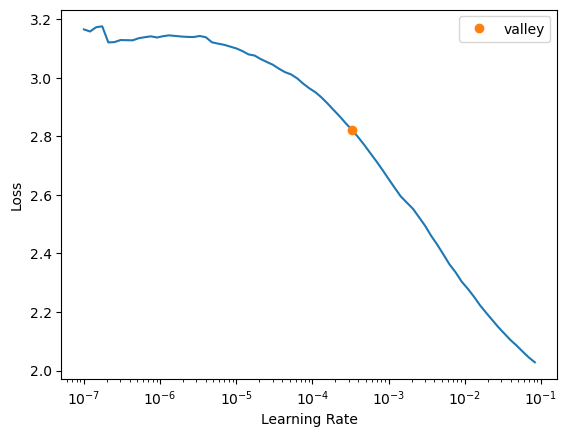

In [16]:
# learning rate finder to set proper learning rate - high slope for loss
learn_den.lr_find()

In [17]:
# training using the one cycle policy - learning rate scheduler
learn_den.fit_one_cycle(200,1e-3,wd=wd)

epoch,train_loss,valid_loss,MSE,PSNR,l1,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.760173,0.727947,0.004135,23.991573,0.035777,0.106817,0.109990,0.109982,0.137540,0.121022,0.106821,06:04
1,0.655484,0.657721,0.003326,25.103834,0.029761,0.104125,0.102678,0.103856,0.113953,0.102488,0.100859,06:07
2,0.624904,0.657173,0.003291,25.194876,0.030489,0.102337,0.101364,0.102306,0.118770,0.102816,0.099089,06:03
3,0.604825,0.599934,0.002141,27.003387,0.022802,0.097731,0.094846,0.098121,0.099621,0.091466,0.095347,06:01
4,0.589748,0.684625,0.008425,21.366335,0.041149,0.107397,0.102993,0.100861,0.128131,0.108320,0.095773,06:02
5,0.577492,0.590399,0.002282,26.768547,0.024371,0.097332,0.093691,0.096176,0.096816,0.088844,0.093168,06:02
6,0.577393,0.575072,0.001885,27.537302,0.021890,0.096233,0.092052,0.095726,0.093069,0.084031,0.092072,06:06
7,0.564303,0.570926,0.001994,27.315535,0.022713,0.094823,0.090833,0.093945,0.092629,0.085010,0.090973,06:04
8,0.564801,0.566515,0.001890,27.526192,0.021406,0.093942,0.090493,0.093524,0.091820,0.085171,0.090159,06:04
9,0.553666,0.579800,0.002202,26.948074,0.022562,0.095373,0.091932,0.094776,0.096648,0.087955,0.090553,06:03


In [18]:
# save model
learn_den.save(fname)

Path('/home/dlohr/mnt_anarchyNAS/lohrd/Github/AIMD/models/Basemodel_Hagen_all.pth')